In [1]:
%load_ext autoreload
%autoreload 2

In [177]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import shutil

from torchinfo import summary
import torch.utils.tensorboard as tb

torch.manual_seed(10);
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_idx = 0

import models_pheno
import models_decode
import models_breed
import mnist
import neuroevolution
import co_neuroevolution
import ordinary_ne
import util



In [3]:
task = mnist.MNIST()
task.load_all_data(device)

In [4]:
# import tempfile
# tb_log_dir = tempfile.mkdtemp()
user = os.getlogin()
tb_log_dir = f'/tmp/tensorboard/{user}'

In [5]:
if os.path.exists(tb_log_dir):
    shutil.rmtree(tb_log_dir)

In [6]:
logger = tb.SummaryWriter(tb_log_dir, flush_secs=5)

In [63]:
torch.manual_seed(1)
np.random.seed(1)
geno_config = {
    'pheno_class': models_pheno.SmallNet,
    'decoder_class': models_decode.IdentityDecoder,
    'breeder_class': models_breed.FirstParentIdentityBreeder,
    
    'dna_mutate_lr': 1e-2,
    'dna_mutate_prob': 0,
    
    'decode_mutate_lr': 1e-2,
    'decode_mutate_prob': 0,
    'decode_weight_init_zeros': False,
    
    'breed_mutate_lr': 1e-3,
    'breed_mutate_prob': 0,
    'breed_weight_init_for_first_parent': True,
    'breeder_init_zeros': True,
    
    'dna_len': 20,
    'dna_init_std': 1e-1,
}

evol_config = {
    'fitness_func': task.calc_pheo_fitness,
    'n_pop': 100,
    'n_gen': 300,
    
    'select_cfg': {
        'k_elite': 5,
        'do_crossover': True,
        'with_replacement': True,
    },
    'fit2prob_cfg': {
        'inv_temp': 5,
        'normalize': True,
    },
}
log_config = {
    'logger': logger,
    'tag': 'temp',
    'save_every_n_gens': 10,
    'save_n_agents': 20,
}

tag = 'learned_rsb_init0'
# logger.add_text(tag, f'NE with config: {config}')

ne = neuroevolution.Neuroevolution(geno_config, evol_config, device=device, verbose=True, logger=logger, tag=tag)
ne.run_evolution(tqdm=tqdm)

# logger.add_hparams(config, {key: value[-1] for key, value in ne.fitdata.items()}, run_name=tag)
# logger.add_hparams(config, {'best_fitness': ne.best_fitness, 'fitness_v_gen_AUC': ne.fitness_v_gen_AUC}, run_name=tag)

Running Neuroevolution with 
Population:  100
Generations:  300
Pheno   # params: 00130
------------------
DNA     # params: 00130
Decoder # params: 00000
Breeder # params: 00000
Total   # params:   130


In [178]:
torch.manual_seed(1)
np.random.seed(1)
geno_config = {
    'pheno_class': models_pheno.SmallNet,
    'decoder_class': models_decode.IdentityDecoder,
    'breeder_class': models_breed.ConvAdvancedRSBBreeder,
    
    'dna_mutate_lr': 1e-2,
    'dna_mutate_prob': 0,
    
    'decode_mutate_lr': 1e-2,
    'decode_mutate_prob': 0,
    'decode_weight_init_zeros': False,
    
    'breed_mutate_lr': 1e-3,
    'breed_mutate_prob': 0,
    'breed_weight_init_for_first_parent': True,
    'breeder_init_zeros': True,
    
    'dna_len': 50,
    'dna_init_std': 1e-1,
}

evol_config = {
    'fitness_func': task.calc_pheo_fitness,
    'n_pop': 100,
    'n_pop_decoder': 10,
    'n_pop_breeder': 10,
    
    'n_gen': 300,
    'n_sample_eval_dna': 3,
    'n_sample_eval_decoder': 3,
    'n_sample_eval_breeder': 3,
    
    'select_cfg': {
        'k_elite': 5,
        'do_crossover': True,
        'with_replacement': True,
    },
    'select_cfg_decoder': {
        'k_elite': 5,
        'do_crossover': False,
        'with_replacement': True,
    },
    'select_cfg_breeder': {
        'k_elite': 5,
        'do_crossover': False,
        'with_replacement': True,
    },
    'fit2prob_cfg': {
        'inv_temp': 5,
        'normalize': True,
    },
}
log_config = {
    'logger': logger,
    'tag': 'temp',
    'save_every_n_gens': 10,
    'save_n_agents': 20,
}

tag = 'learned_rsb_init0'
# logger.add_text(tag, f'NE with config: {config}')

co_ne = co_neuroevolution.Neuroevolution(geno_config, evol_config, device=device, verbose=True, logger=logger, tag=tag)
co_ne.run_evolution(tqdm=tqdm)

# logger.add_hparams(config, {key: value[-1] for key, value in ne.fitdata.items()}, run_name=tag)
# logger.add_hparams(config, {'best_fitness': ne.best_fitness, 'fitness_v_gen_AUC': ne.fitness_v_gen_AUC}, run_name=tag)

Running Neuroevolution with 
Population:  100
Generations:  300
Pheno   # params: 00130
------------------
DNA     # params: 00130
Decoder # params: 00000
Breeder # params: 00053
Total   # params:   183


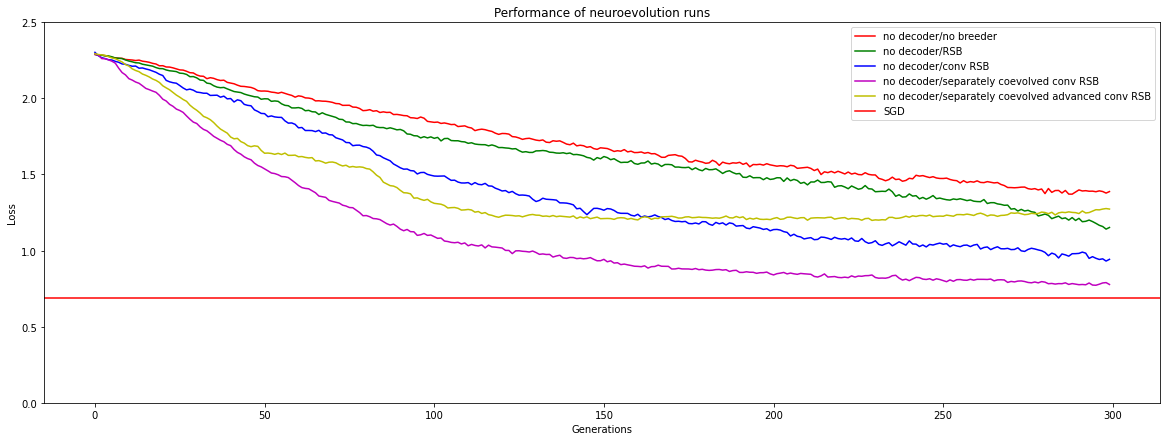

In [182]:
plt.figure(figsize=(20, 7))
ind = [0]
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_base.fitdata_gens))['loss'], axis=-1)[:, ind], c='r', label='no decoder/no breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_rsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='g', label='no decoder/RSB')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_lrsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='b', label='no decoder/conv RSB')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(co_ne_lrsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='m', label='no decoder/separately coevolved conv RSB')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(co_ne_adv_lrsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='y', label='no decoder/separately coevolved advanced conv RSB')
plt.axhline(torch.load('data/mnist_sgd_eval')[models_pheno.SmallNet]['loss'], c='r', label='SGD')
plt.title('Performance of neuroevolution runs')
plt.xlabel('Generations'); plt.ylabel('Loss')
plt.ylim(0, 2.5); plt.legend()
plt.show()

In [204]:
task.perform_stats(net, device=device)

Average Loss: 2.388, Accuracy: 8.920%


{'loss': 2.3875574111938476, 'accuracy': 8.92}

In [261]:
import cma
model = models_pheno.SmallNet
net = model().to(device)


def pheno_fitness(sol, net=net):
    sol = torch.tensor(sol, device=device).to(torch.float32)
#     sol = torch.tanh(sol)
    
    
    net = util.vec2model(sol, net).to(device)
    
    torch.manual_seed(0)
    fit = task.calc_pheo_fitness(net, n_sample=1000, device=device)['loss']
    
    if np.isinf(fit) or np.isnan(fit):
        torch.manual_seed(0)
        idx = torch.randperm(len(task.X_train))[:1000]
        X_batch, Y_batch = task.X_train[idx].to(device), task.Y_train[idx].to(device)
        Y_batch_pred = net(X_batch)
        n_correct = (Y_batch_pred.argmax(dim=-1)==Y_batch).sum().item()
        loss = nn.NLLLoss(reduction='none')(Y_batch_pred, Y_batch)
#         accuracy = n_correct/len(Y_batch)*100.
        
        i = torch.isinf(loss).to(torch.float32).argsort()[-1]
        
        print(Y_batch_pred[i])
        print(Y_batch[i])
        print('-----')
        plt.bar(np.arange(10), Y_batch_pred[i].detach().cpu().numpy())
        plt.bar(Y_batch[i].item(), .1)
        
        raise 'hello'
        
        
    
    return fit

sol = [l for l in util.model2vec(net).detach().cpu().numpy()]

es = cma.CMAEvolutionStrategy(sol, 1e-2, {'popsize':101})
es.optimize(pheno_fitness)

(50_w,101)-aCMA-ES (mu_w=27.2,w_1=8%) in dimension 130 (seed=365780, Wed Jun  9 15:45:16 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    101 2.316961765289307e+00 1.0e+00 9.45e-03  9e-03  9e-03 0:00.4
    2    202 2.315339565277100e+00 1.0e+00 9.45e-03  9e-03  9e-03 0:00.7
    3    303 2.314204931259155e+00 1.0e+00 9.78e-03  1e-02  1e-02 0:01.1
   12   1212 2.294106245040894e+00 1.1e+00 2.80e-02  3e-02  3e-02 0:04.2
   24   2424 2.054770231246948e+00 1.1e+00 1.49e-01  1e-01  2e-01 0:08.5
   39   3939 1.979456901550293e+00 1.1e+00 2.93e-01  3e-01  3e-01 0:13.7
   57   5757 1.916270017623901e+00 1.2e+00 2.95e-01  3e-01  3e-01 0:19.9
   78   7878 1.724502801895142e+00 1.4e+00 2.35e-01  2e-01  2e-01 0:27.3
  100  10100 1.595139980316162e+00 1.5e+00 2.20e-01  2e-01  2e-01 0:34.9
  126  12726 1.481571316719055e+00 1.7e+00 2.05e-01  2e-01  2e-01 0:44.0
  155  15655 1.296234250068665e+00 1.9e+00 1.53e-01  1e-01  2e-01 0:54.2
  187  18887 1.173522591590881

KeyboardInterrupt: 

In [38]:
a = np.min(util.arr_dict2dict_arr(ne1.calc_fitdata(ne1.pop))['loss'])

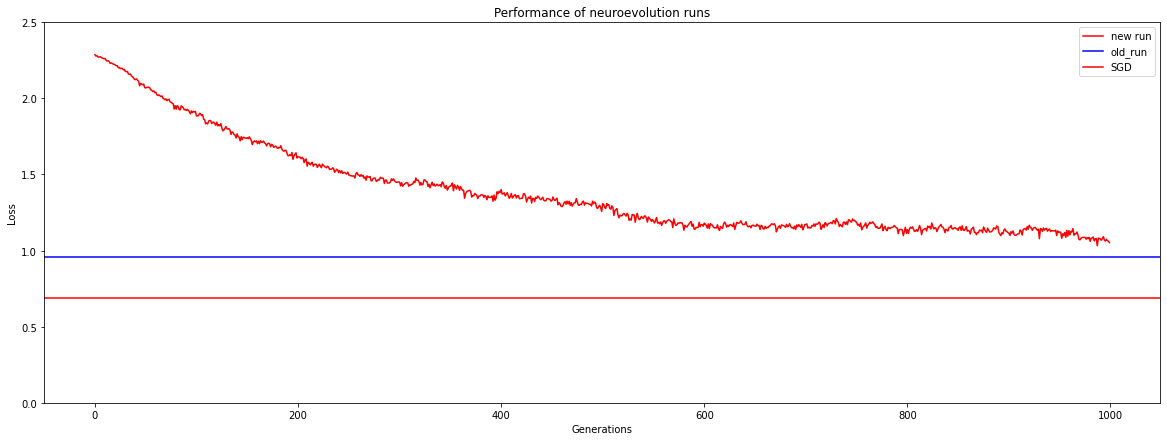

In [39]:
plt.figure(figsize=(20, 7))
ind = [0]
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne.fitdata_gens))['loss'], axis=-1)[:, ind], c='r', label='new run')
# plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne1.fitdata_gens))['loss'], axis=-1)[:, ind], c='b', label='old run')
# plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_lrsb_init0.fitdata_gens))['loss'], axis=-1)[:, ind], c='g', label='learned conv rsb breeder init 0')
plt.axhline(a, c='b', label='old_run')
plt.axhline(torch.load('data/mnist_sgd_eval')[models_pheno.SmallNet]['loss'], c='r', label='SGD')
plt.title('Performance of neuroevolution runs')
plt.xlabel('Generations'); plt.ylabel('Loss')
plt.ylim(0, 2.5); plt.legend()
plt.show()

In [10]:
torch.load('data/mnist_sgd_eval')

{models_pheno.SmallNet: {'fitness': -0.6912355422973633,
  'loss': 0.6912355422973633,
  'accuracy': 78.32249999999999},
 models_pheno.ConvNet: {'fitness': -0.28138837218284607,
  'loss': 0.28138837218284607,
  'accuracy': 91.6425},
 models_pheno.BigConvNet: {'fitness': -0.10598196089267731,
  'loss': 0.10598196089267731,
  'accuracy': 96.65}}

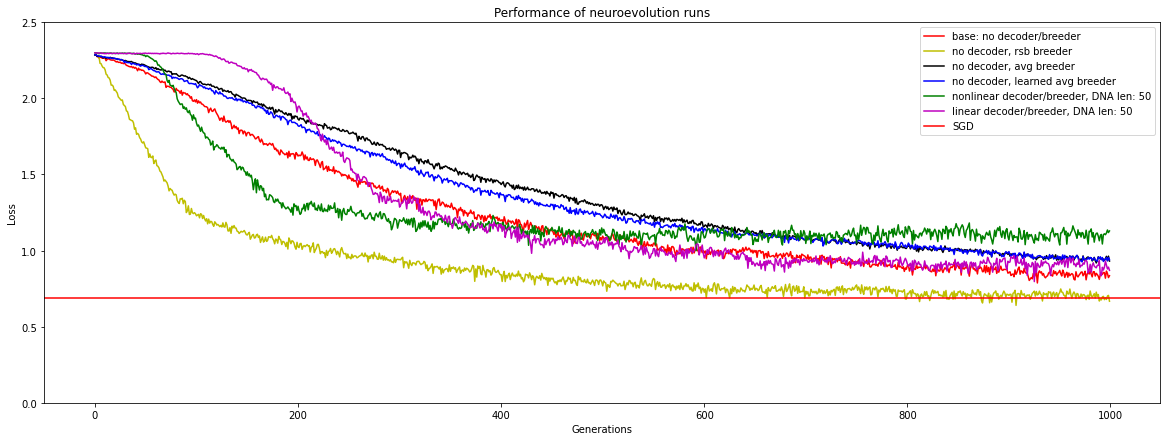

In [95]:
plt.figure(figsize=(20, 7))
x = np.arange(1000)
# plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne.fitdata_gens))['fitness'], axis=-1)[:, -1], label='hardcoded breeder')
# y = np.sort(util.arr_dict2dict_arr(np.array(ne_base.fitdata_gens))['loss'], axis=-1)[:, [0, -1]]
# plt.errorbar(x=x, y=y.mean(axis=-1), yerr=(y[:, 1]-y[:, 0])/2., c='b', elinewidth=0.5, label='base_ne')
# y = np.sort(util.arr_dict2dict_arr(np.array(ne_rsb.fitdata_gens))['loss'], axis=-1)[:, [0, -1]]
# plt.errorbar(x=x, y=y.mean(axis=-1), yerr=(y[:, 1]-y[:, 0])/2., c='g', elinewidth=0.5, label='random swap breeder')
# y = np.sort(util.arr_dict2dict_arr(np.array(ne_avg.fitdata_gens))['loss'], axis=-1)[:, [0, -1]]
# plt.errorbar(x=x, y=y.mean(axis=-1), yerr=(y[:, 1]-y[:, 0])/2., c='k', elinewidth=0.5, label='average breeder')
# y = np.sort(util.arr_dict2dict_arr(np.array(ne_nonlin.fitdata_gens))['loss'], axis=-1)[:, [0, -1]]
# plt.errorbar(x=x, y=y.mean(axis=-1), yerr=(y[:, 1]-y[:, 0])/2., c='y', elinewidth=0.5, label='nonlinear')

ind = [0]

plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_base.fitdata_gens))['loss'], axis=-1)[:, ind], c='r', label='base: no decoder/breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_rsb.fitdata_gens))['loss'], axis=-1)[:, ind], c='y', label='no decoder, rsb breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_avg.fitdata_gens))['loss'], axis=-1)[:, ind], c='k', label='no decoder, avg breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_lavg.fitdata_gens))['loss'], axis=-1)[:, ind], c='b', label='no decoder, learned avg breeder')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_nonlin.fitdata_gens))['loss'], axis=-1)[:, ind], c='g', label='nonlinear decoder/breeder, DNA len: 50')
plt.plot(np.sort(util.arr_dict2dict_arr(np.array(ne_lin.fitdata_gens))['loss'], axis=-1)[:, ind], c='m', label='linear decoder/breeder, DNA len: 50')
plt.axhline(torch.load('data/mnist_sgd_eval')[models_pheno.SmallNet]['loss'], c='r', label='SGD')
plt.title('Performance of neuroevolution runs')
plt.xlabel('Generations'); plt.ylabel('Loss')
plt.ylim(0, 2.5); plt.legend()
plt.show()

In [107]:
geno = ne_rsb.pop[np.argmax(util.arr_dict2dict_arr(ne_rsb.fitdata)['fitness'])]
pheno = geno.load_pheno(models_decode.IdentityDecoder(), models_pheno.SmallNet().to(device))
task.perform_stats(pheno, device=device)
task.calc_pheo_fitness(pheno, device=device)

Average Loss: 0.733, Accuracy: 76.700%


{'fitness': -0.7590956091880798, 'loss': 0.7590956091880798, 'accuracy': 76.35}

In [61]:
import population

In [83]:
pheno = models_pheno.ConvNet().to(device)
decoder = models_decode.IdentityDecoder()

fits = np.zeros((2, 2, 1000))
for nei, ne in enumerate([ne1, ne2]):
    for bi, breeder in enumerate([models_breed.AverageBreeder(), models_breed.RandomSwapBreeder()]):
        prob = population.fit2prob_sm(ne.fitdata['fitness'], fit2prob_sm_iT=1., fit2prob_sm_normalize=False)
        for i in tqdm(range(1000)):
            geno1, geno2 = np.random.choice(ne.pop, size=(2), p=prob)
            dna = breeder.breed_dna(geno1.dna, geno2.dna)
            geno = neuroevolution.CombinedGenotype(dna, geno1.decoder_dna, geno1.breeder_dna)
            pheno = geno.to_pheno(decoder, pheno)
            fits[nei, bi, i] = task.calc_pheo_fitness(pheno, device=device)['fitness']


(-1.3, -0.7)

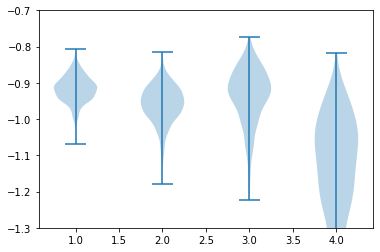

In [84]:
plt.violinplot(fits.reshape(4, 1000).T);
plt.ylim(-1.3, -.7)

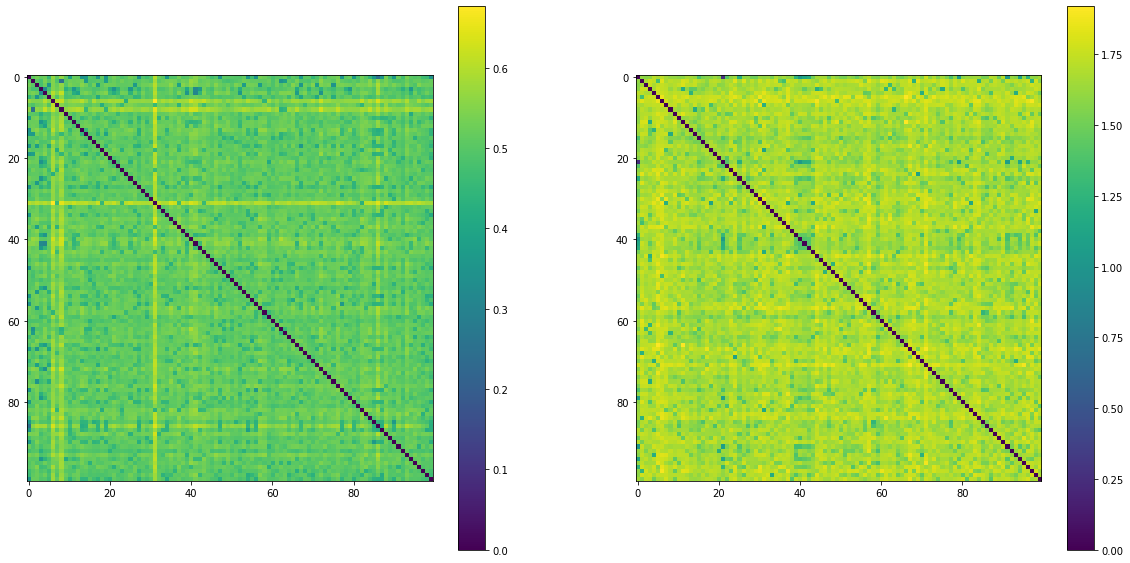

In [82]:
plt.figure(figsize=(20,10))
for nei, ne in enumerate([ne1, ne2]):
    plt.subplot(1,2,nei+1)
    a = torch.stack([geno.dna for geno in ne.pop]).cpu()
    plt.imshow((a[:, None] - a[None, :]).norm(dim=-1).numpy())
    plt.colorbar()


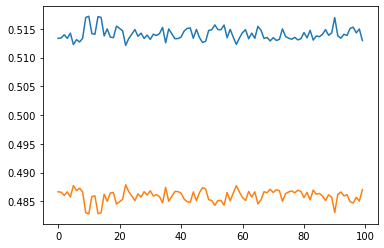

In [40]:
plt.plot(np.stack([geno.breeder_dna.cpu().softmax(dim=-1).numpy() for geno in ne.pop]))
# plt.scatter(np.ones(2), ne.pop[0].breeder_dna.cpu().softmax(dim=-1).numpy())

In [13]:
run_idx = 0
for trial_idx in range(5):
    for breed_mutate_lr in [0, 1e-4, 1e-2]:
        for breed_weight_init_for_first_parent in [True, False]:
            run_idx += 1
            torch.manual_seed(trial_idx)
            np.random.seed(trial_idx)
            batch_idx = 21
            config = {
                'breed_weight_init_for_first_parent': breed_weight_init_for_first_parent,
                'mutate_lr': 1e-2,
                'mutate_prob': 1e-3,
                'breed_mutate_lr': breed_mutate_lr,
                'breed_mutate_prob': 0,
                'n_pop': 100,
                'n_gen': 500,
                'prob_sm_const': 1.,
                'n_elite': 5,
                'with_replacement': True,
            }
            tag = f'run {run_idx:03d}'
            logger.add_text(tag, f'Trial {trial_idx}, NE with config: {config}')
            
            ne = neuroevolution.Neuroevolution(models.SmallNet, Breeder, calc_pheo_fitness, config, device=device)
            ne.run_evolution(tqdm=tqdm, logger=logger, tag=tag)
            
#             logger.add_hparams(config, {key: value[-1] for key, value in ne.fitdata.items()}, run_name=tag)
            logger.add_hparams(config, {'best_fitness': ne.best_fitness, 'fitness_v_gen_AUC': ne.fitness_v_gen_AUC}, run_name=tag)

KeyboardInterrupt: 

In [13]:
import co_crossover_ne

ne = co_crossover_ne.COCrossoverNE(models.SmallNet, CONet, calc_pheo_fitness, config, device=device)

ne.run_evolution(tqdm=tqdm, logger=logger)

TypeError: __init__() missing 1 required positional argument: 'config'

In [29]:
first_parent_weight_init=True

In [18]:
torch.manual_seed(0)
conet = CONet(config).to(device)
a = torch.randn_like(v).to(device)
b = torch.randn_like(v).to(device)
c = conet.crossover(a, b).detach()
(c-a).abs().max().item(), (c-b).abs().max().item()

Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)


(0.0, 3.999563694000244)

In [ ]:

def calc_pheo_fitness(net):
    global batch_idx
#     batch_idx, (X_batch, Y_batch) = next(enumerate(mnist.train_loader))
    X_batch, Y_batch = X_train[batch_idx].to(device), Y_train[batch_idx].to(device)
    batch_idx = (batch_idx+1)%len(X_train)
    
#     Y_batch_pred, bef, aft = net(X_batch)
    Y_batch_pred = net(X_batch)
    n_correct = (Y_batch_pred.argmax(dim=-1)==Y_batch).sum().item()
    loss = mnist.loss_func(Y_batch_pred.log(), Y_batch).item()
    if not np.isfinite(loss):
        for i in range(len(Y_batch_pred)):
            loss = mnist.loss_func(Y_batch_pred[[i]].log(), Y_batch[[i]]).item()
            if not np.isfinite(loss):
                temp = Y_batch_pred[[i]].detach().cpu().numpy()
                plt.bar(np.arange(10), temp.flatten())
                plt.show()
                plt.imshow(X_batch[[i]].cpu().numpy()[0,0])
                plt.show()
                print(temp)
                print(Y_batch[[i]])
                plt.subplot(132)
                temp = list(net.parameters())[-2].detach().cpu().numpy()
                plt.imshow(temp);plt.colorbar()
                plt.subplot(133)
                temp = bef[[i]].T.detach().cpu().numpy()
                plt.imshow(temp);plt.colorbar()
                plt.subplot(131)
                temp = aft[[i]].detach().cpu().numpy()
                plt.imshow(temp);plt.colorbar()
                plt.show()
                temp = aft[[i]].detach().cpu().numpy()
                plt.imshow(temp);plt.colorbar()
                plt.show()
                raise Exception()
        
        
    accuracy = n_correct/len(Y_batch)
    
    return {'fitness': -loss, 'loss': loss, 'accuracy': accuracy}


In [40]:
for a_idx, amount in enumerate(amounts):
    print(f'mean: {data[:, a_idx, -1].mean(dim=0): .3f}, std: {data[:, a_idx, -1].std(dim=0):.3f}, amount:{amounts[a_idx]: .1e}')

mean: -0.523, std: 0.497, amount: 1.0e-09
mean: -0.480, std: 0.197, amount: 1.0e-03
mean: -0.577, std: 0.182, amount: 1.0e-02
mean: -0.341, std: 0.111, amount: 1.0e-01
mean: -0.355, std: 0.136, amount: 1.0e+00
mean: -0.342, std: 0.147, amount: 1.0e+01


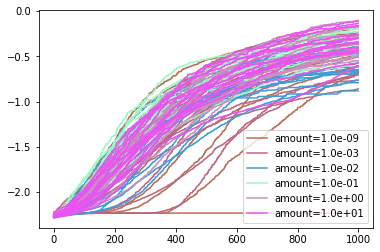

In [24]:
for a_idx, amount in enumerate(amounts):
    c = np.random.uniform(size=3)
    for trial_idx in range(15):
        label=None
        if trial_idx==0:
            label=label=f'amount={amount:.1e}'
        plt.errorbar(np.arange(1000), data[trial_idx, a_idx].numpy(), yerr=None, c=c, label=label)
plt.legend()

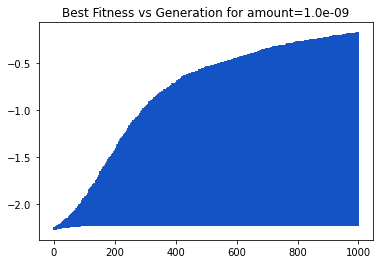

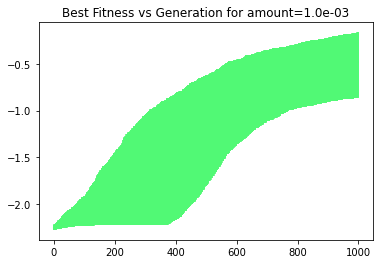

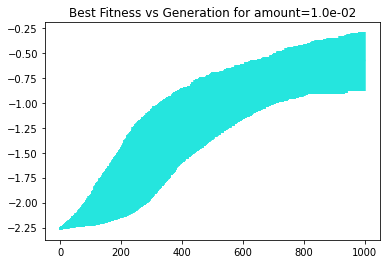

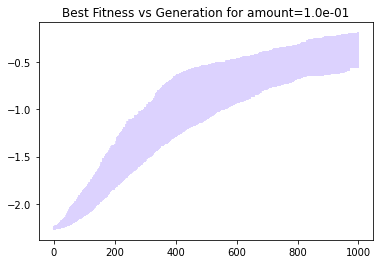

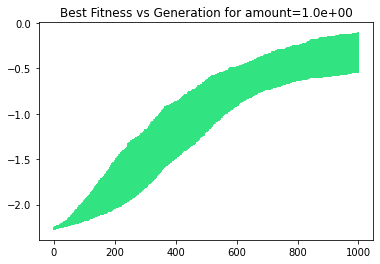

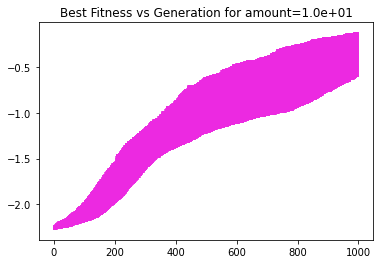

In [28]:
for a_idx, amount in enumerate(amounts):
    c = np.random.uniform(size=3)
    label=label=f'amount={amount:.1e}'
    d = data[:, a_idx]
    yerr = d.std(dim=0)
    yerr = torch.stack([d.min(dim=0).values-d.mean(dim=0), d.max(dim=0).values-d.mean(dim=0)], dim=0).abs()
    plt.errorbar(np.arange(1000), d.mean(dim=0).numpy(),
                 yerr=yerr.numpy(), c=c, label=label)
    plt.title(f'Best Fitness vs Generation for amount={amount:.1e}')
    plt.show()
# plt.legend()

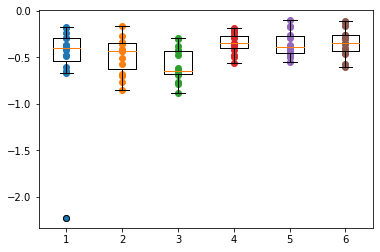

In [56]:
# for a_idx, amount in enumerate(amounts):
#     plt.boxplot(data[:, a_idx, -1].numpy())
plt.boxplot(data[:, :, -1].numpy())

for a_idx, amount in enumerate(amounts):
    d = data[:, a_idx, -1]
    plt.scatter(np.ones_like(d)*(a_idx+1), d.numpy())
plt.show()

In [30]:
data.numel()

90000

torch.Size([15, 3, 500])

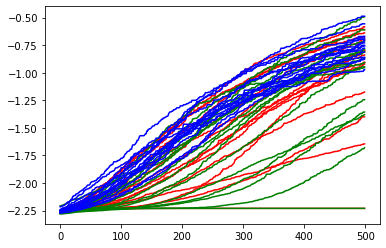

In [53]:
for trial_idx in range(15):
    plt.errorbar(np.arange(500), d[trial_idx, 0].numpy(), yerr=None, c='r')
for trial_idx in range(15):
    plt.errorbar(np.arange(500), d[trial_idx, 1].numpy(), yerr=None, c='g')
for trial_idx in range(15):
    plt.errorbar(np.arange(500), d[trial_idx, 2].numpy(), yerr=None, c='b')
d.shape